# Wybór najlepszych cech zmiennej niezależnej



In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In [154]:
score_summary = {}
df = pd.read_csv("https://raw.githubusercontent.com/marianwitkowski/python-data/master/feat-eng/otodom.csv")
df.head()

,id,cena,liczba_pieter,liczba_pokoi,pietro,powierzchnia,rok_budowy
0,46lCR,979000,5,4,5,83.00,2009
1,44Utr,1400000,7,3,2,82.94,2011
2,3Bdli,640659,4,3,2,64.13,2019
3,46q1p,410000,12,2,4,36.30,1975
4,468dI,415900,10,2,6,31.06,1974


## Liczba wybieranych cech

In [155]:
N_FEAT = 3 # liczba cech do wyboru

In [156]:
X = df.iloc[:, 2:]
y = df.cena
y.name = 'result'

## Estymator dla danych oryginalnych

In [157]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(score)
score_summary["ORYG"] = score


0.6935208783964221


## Korelacja pomiędzy cechami a zmienną zależną

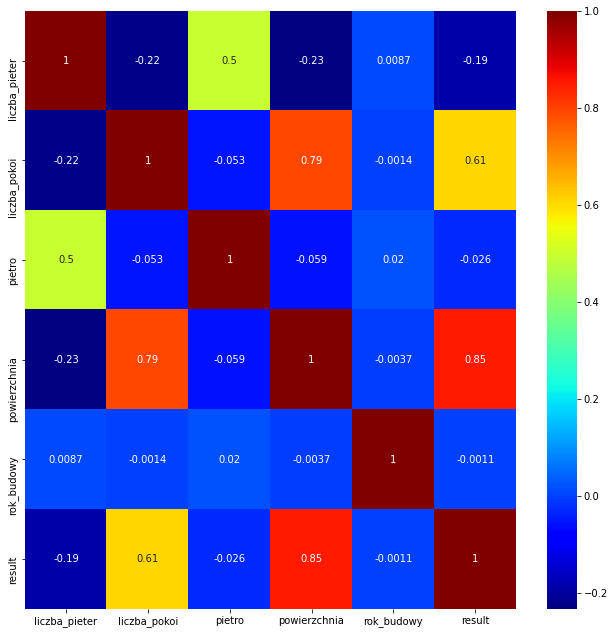

In [158]:
plt.figure(figsize=(11,11))
sns.heatmap( pd.concat([X,y], axis=1).corr(), cmap='jet', annot=True  )

## Wybór cech na podstawie największej (bezwzględnie) korelacji

In [159]:

# pobranie kolumn z najw. (bezwzględnie) wartością korelacji
series = pd.concat([X,y], axis=1).corr().iloc[-1].abs().sort_values(ascending=False).iloc[1:N_FEAT+1]

best_cols = list(series.index)
print(best_cols)

X_train, X_test, y_train, y_test = train_test_split(X[best_cols], y, test_size=.2, random_state=0)
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(score)
score_summary["Correlation"] = score


['powierzchnia', 'liczba_pokoi', 'liczba_pieter']
0.6730135958443856


## Użycie klasy SelectKBest

In [160]:
# wybieranie cech z wykorzystaniem klasy SelectKBest
from sklearn.feature_selection import SelectKBest, f_classif

# ekstracja w oparciu o test ANOVA
fe = SelectKBest(f_classif, k=N_FEAT)
fe.fit(X, y)

best_cols = X.loc[ : , fe.get_support() ].columns.tolist()
print(best_cols)

X_train, X_test, y_train, y_test = train_test_split(X[best_cols], y, test_size=.2, random_state=0)
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(score)
score_summary["SelectKBest"] = score


['liczba_pieter', 'liczba_pokoi', 'powierzchnia']
0.6730135958443856


## Użycie techniki Recursive Feature Extraction

In [161]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

rfe = RFE(estimator=DecisionTreeClassifier() , n_features_to_select=N_FEAT)
rfe.fit(X, y)

best_cols = X.loc[ : , rfe.get_support() ].columns.tolist()
print(best_cols)

X_train, X_test, y_train, y_test = train_test_split(X[best_cols], y, test_size=.2, random_state=0)
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(score)
score_summary["RFE"] = score


['pietro', 'powierzchnia', 'rok_budowy']
0.722047972814522


## Użycie klasy SelectFromModel

In [162]:
# Technika "opakowywania" - wybieranie najlepszych cech na podstawie działania estymatora ML
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

ens = SelectFromModel(estimator=RandomForestClassifier() , max_features=N_FEAT )
ens.fit(X, y)

best_cols = X.loc[ : , ens.get_support() ].columns.tolist()
print(best_cols)

X_train, X_test, y_train, y_test = train_test_split(X[best_cols], y, test_size=.2, random_state=0)
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(score)
score_summary["SelectFromModel"] = score


['powierzchnia', 'rok_budowy']
0.7396100159459125


## Analiza składowych głównych - PCA

In [163]:
# import klasy odpowiedzialnej za PCA
from sklearn.decomposition import PCA

In [164]:
# inicjalizacja obiekty klasy PCA z nową liczbą wymiarów zm. niezależnej
pca = PCA(n_components=N_FEAT, random_state=0)

In [165]:
# redukacja wymiarowości
x_pca = pca.fit_transform(X)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(x_pca, y, test_size=.2, random_state=0)
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(score)
score_summary["PCA"] = score


0.4418608358900445


# Wyniki

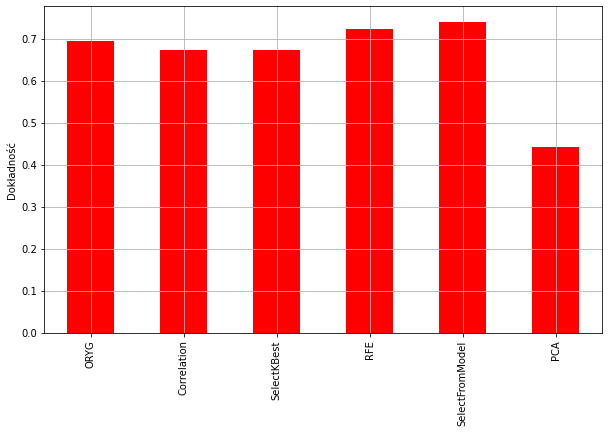

In [167]:
pd.DataFrame(score_summary, index=[0]).T.plot(kind='bar', legend=False, figsize=(10,6), color='r', grid=True)
plt.ylabel('Dokładność')
plt.show()